In [41]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import pickle
import logging
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import warnings;
warnings.filterwarnings('ignore');

In [4]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Root directory for dataset
dataroot = "/content/gdrive/My Drive/dataset2/"
#Directory for saving results
save_dir = '/content/gdrive/My Drive/Result_post_op_aligned_data/'

In [0]:
#src = ImageImageList.from_folder(dataroot).split_by_rand_pct(valid_pct=0.2)
data_path="/content/gdrive/My Drive/dataset2/medimages/"

In [7]:
#Image file names
data_path="/content/gdrive/My Drive/dataset2/medimages/"
fnames = get_image_files(data_path)
fnames[:5]

[PosixPath('/content/gdrive/My Drive/dataset2/medimages/10_2.png'),
 PosixPath('/content/gdrive/My Drive/dataset2/medimages/117_1.png'),
 PosixPath('/content/gdrive/My Drive/dataset2/medimages/117_2.png'),
 PosixPath('/content/gdrive/My Drive/dataset2/medimages/102_2.png'),
 PosixPath('/content/gdrive/My Drive/dataset2/medimages/125_1.png')]

In [0]:
#Pattern for generating the label from Image file name
pat = r'(\d+)\.png$'
#Transformations to apply on Image dataset
tfms = get_transforms(max_rotate=5.0, max_zoom=1.0, max_lighting=0.4,
                      max_warp=0, p_affine=1.0, p_lighting=1.0)
#Dataset
dataset = ImageDataBunch.from_name_re(data_path, fnames, pat, ds_tfms=tfms, size=64, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)

In [0]:
# import pickle
# pickle.dump(img_labels, open("img_labels", 'wb'))

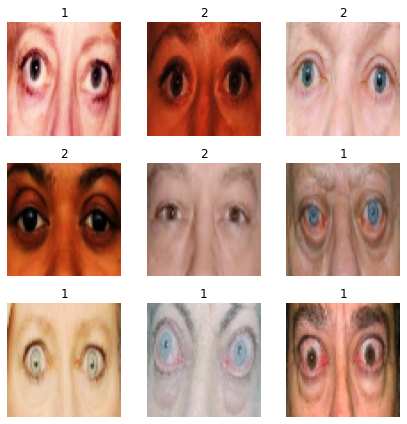

In [9]:
#Showing images from training dataset
dataset.show_batch(ds_type=DatasetType.Train, rows=3, figsize=(6,6))

In [0]:
dataloader=dataset.train_dl

In [0]:
#Hyperparameters
image_size = 64
label_dim = 2
G_input_dim = 100
G_output_dim = 3
D_input_dim = 3
D_output_dim = 1
num_filters = [1024, 512, 256, 128]
learning_rate = 0.0002
betas = (0.5, 0.5)
batch_size = 64
num_epochs = 100
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
# # For logger
# def to_np(x):
#     return x.data.cpu().numpy()
# def to_var(x):
#     if torch.cuda.is_available():
#         x = x.cuda()
#     return Variable(x)

In [0]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [0]:
# Generator model
class Generator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())
        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out
                

In [0]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


In [0]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir=save_dir, show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Post_op_cDCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [0]:
def plot_result(generator, noise, label, num_epoch, save=False, save_dir=save_dir, show=False, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        # ax.imshow(img.cpu().data.view(image_size, image_size, 3).numpy(), cmap=None, aspect='equal')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Post_op_cDCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)
    
    # if num_epochs %10==0 && show=True
    #     plt.show()
    # else:
    #     plt.close()
    
    if show:
        plt.show()
    else:
        plt.close()


In [0]:
def plot_morp_result(generator, save=False, save_dir=save_dir, show=False, fig_size=(10, 10)):
    source_z_ = torch.randn(10, G_input_dim)
    z_ = torch.zeros(10*10, G_input_dim)
    for i in range(5):
        for j in range(10):
            z_[i * 20 + j] = (source_z_[i * 2 + 1] - source_z_[i * 2]) / 9 * (j + 1) + source_z_[i * 2]

    for i in range(5):
        z_[i * 20 + 10:i * 20 + 20] = z_[i * 20:i * 20 + 10]

    y_ = torch.cat([torch.zeros(10, 1), torch.ones(10, 1)], 0).type(torch.LongTensor).squeeze()
    y_ = torch.cat([y_, y_, y_, y_, y_], 0)
    y_label_ = onehot[y_]
    noise = z_.view(-1, G_input_dim, 1, 1)
    label = y_label_.view(-1, label_dim, 1, 1)

    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Post_op_cDCGAN_noise_morp.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


In [138]:
# Models
G = Generator(G_input_dim, label_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, label_dim, num_filters[::-1], D_output_dim)
G.cuda()
D.cuda()

Discriminator(
  (hidden_layer1): Sequential(
    (input_conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (input_act): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (label_conv): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (label_act): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer): Sequential(
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.2)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): LeakyReL

In [0]:
#

In [0]:
# Loss function
criterion = torch.nn.BCELoss()

In [0]:
# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

In [0]:
#with open('../Data/celebA_data/hair_label.pkl', 'rb') as fp:
  # img_labels = pickle.load(open("img_labels", 'rb'))
  # labels_torch = torch.LongTensor(img_labels).squeeze()

In [0]:
# Label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

In [0]:
# fixed noise & label
temp_noise0_ = torch.randn(4, G_input_dim)
temp_noise0_ = torch.cat([temp_noise0_, temp_noise0_], 0)
temp_noise1_ = torch.randn(4, G_input_dim)
temp_noise1_ = torch.cat([temp_noise1_, temp_noise1_], 0)

fixed_noise = torch.cat([temp_noise0_, temp_noise1_], 0)
fixed_label = torch.cat([torch.zeros(4), torch.ones(4), torch.zeros(4), torch.ones(4)], 0).type(torch.LongTensor).squeeze()

fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
fixed_label = onehot[fixed_label]


In [0]:
# Training GAN
D_avg_losses = []
G_avg_losses = []

In [144]:
step = 0
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    if epoch == 5 or epoch == 10:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10

    # minibatch training
    for i, (images, img_label) in enumerate(dataloader):

        # image data
        mini_batch = images.size()[0]
        x_ = Variable(images.cuda())

        # labels
        y_real_ = Variable(torch.ones(mini_batch).cuda())
        y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        c_label_ = img_label
       
        c_fill_ = Variable(fill[c_label_].cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, c_fill_).squeeze()
        D_real_loss = criterion(D_real_decision, y_real_)
       # D_real_loss.backward()

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image.detach(), c_fill_).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)
        #D_fake_loss.backward()

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.data)
        G_losses.append(G_loss.data)

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(dataloader), D_loss.data, G_loss.data))

        
    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True, save_dir=save_dir)

    # Show result for fixed noise
    plot_result(G, fixed_noise, fixed_label, epoch, save=True, save_dir=save_dir)

Epoch [1/100], Step [1/2], D_loss: 1.9266, G_loss: 11.6671
Epoch [1/100], Step [2/2], D_loss: 8.3626, G_loss: 15.4442
Epoch [2/100], Step [1/2], D_loss: 4.6541, G_loss: 14.8322
Epoch [2/100], Step [2/2], D_loss: 4.5642, G_loss: 18.6019
Epoch [3/100], Step [1/2], D_loss: 0.9078, G_loss: 20.4392
Epoch [3/100], Step [2/2], D_loss: 0.5468, G_loss: 14.2201
Epoch [4/100], Step [1/2], D_loss: 1.8216, G_loss: 15.9038
Epoch [4/100], Step [2/2], D_loss: 4.3122, G_loss: 23.0238
Epoch [5/100], Step [1/2], D_loss: 1.4881, G_loss: 18.1148
Epoch [5/100], Step [2/2], D_loss: 0.1451, G_loss: 13.3266
Epoch [6/100], Step [1/2], D_loss: 0.7434, G_loss: 2.5735
Epoch [6/100], Step [2/2], D_loss: 0.3598, G_loss: 3.7716
Epoch [7/100], Step [1/2], D_loss: 0.0959, G_loss: 4.8774
Epoch [7/100], Step [2/2], D_loss: 0.1747, G_loss: 5.8127
Epoch [8/100], Step [1/2], D_loss: 0.1018, G_loss: 4.4951
Epoch [8/100], Step [2/2], D_loss: 0.3349, G_loss: 5.8153
Epoch [9/100], Step [1/2], D_loss: 0.1221, G_loss: 3.7657
Epoc

In [0]:
# Make gif
loss_plots = []
gen_image_plots = []
for epoch in range(num_epochs):
    # plot for generating gif
    save_fn1 = save_dir + 'Post_op_cDCGAN_losses_epoch_{:d}'.format(epoch + 1) + '.png'
    loss_plots.append(imageio.imread(save_fn1))

    save_fn2 = save_dir + 'Post_op_cDCGAN_epoch_{:d}'.format(epoch + 1) + '.png'
    gen_image_plots.append(imageio.imread(save_fn2))

imageio.mimsave(save_dir + 'Post_op_cDCGAN_losses_epochs_{:d}'.format(num_epochs) + '.gif', loss_plots, fps=5)
imageio.mimsave(save_dir + 'Post_op_cDCGAN_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

# plot noise morp result
plot_morp_result(G, save=True, save_dir=save_dir)

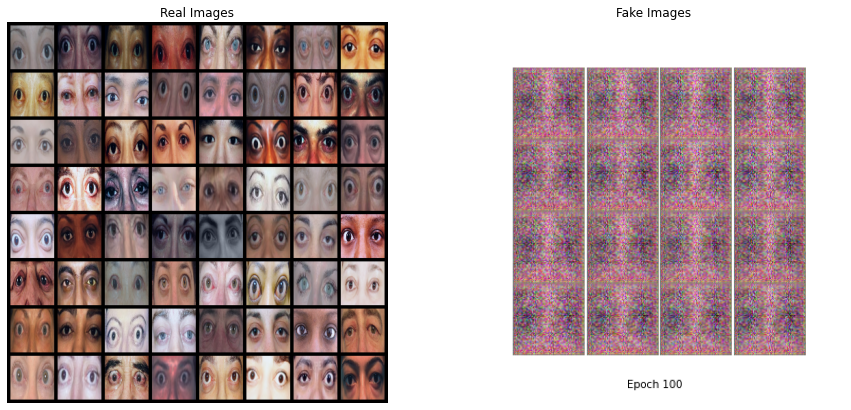

In [149]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(gen_image_plots[-1])
plt.show()